In [1]:
###########################################################################################################################
#
# Antonio Vieira da Silva Neto - NUSP  5690149 - Doutorando em Ciências
# Henrique Lefundes da Silva   - NUSP 11808280 - Pesquisador de Iniciação Científica e Graduando em Engenharia Elétrica
#
# Escola Politécnica da Universidade de São Paulo
# Programa de Pós-Graduação em Engenharia Elétrica
# Departamento de Engenharia de Computação e Sistemas Digitais
# Área de Concentração: Confiabilidade e Segurança
#
# Tese de Doutorado: Safety ArtISt: Um Método para a Garantia de Segurança Crítica de Sistemas com Inteligência Artificial
#
# Estudo de Caso 4 - Sistema de Controle de Frenagem de Veículos
#
# Arquivo para geração do modelo base de IA
#
###########################################################################################################################

###########################################################################################################################
#
# Tabela de Controle de Versões do Código
#
#--------|-------------------|------------------------------|--------------------------------------------------------------
# Versão | Data (dd/mm/aaaa) | Autor                        | Descrição da Versão
#--------|-------------------|------------------------------|--------------------------------------------------------------
#   01   |    28/07/2022     | Henrique Lefundes da Silva   | Versão inicial.
#--------|-------------------|------------------------------|--------------------------------------------------------------
#   01   |    04/08/2022     | Henrique Lefundes da Silva   | Testes com diferentes datasets; função de testes automáticos;
#        |                   |                              | Árvore com dataset estraficado.
#--------|-------------------|------------------------------|--------------------------------------------------------------
#   03   |    29/12/2022     | Henrique Lefundes da Silva   | Multiplas árvores criadas, com diferentes tipos de estrafica-
#        |                   |                              | ção; função de votação de saídas; conversão das árvores uti-
#        |                   |                              | lizando o Conifer; Análise de erros da floresta aletória em 
#        |                   |                              | HDL; Análise da influência da precisão no erro.
#--------|-------------------|------------------------------|--------------------------------------------------------------
###########################################################################################################################

# Importação de Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report 
from stratify import StratifyData
from scipy.stats import mode

In [2]:
# Pré-processamento dos dados (pre_processing)

def pre_processing(address):
    dataColumns = ["Distância Ruidosa", "Velocidade Ruidosa", "Capacidade de Frenagem Ruidosa",
                    "Decisão"]
    
    dataset = pd.read_csv(address, header = None, names = dataColumns)
    
    return dataset

In [3]:
# Função criada para automatizar o processo de testes para diferentes datasets, 
# caso queira testar a árvore no dataset de testes 1, basta chamar automatic_test(1)
# Nome padrão dos datasets de teste: DatasetTX, onde X corresponde a numeração do dataset

def automatic_test(dataset_test_number, decision_tree): 
    # Lê base de dados 
    pp_dataset_test = pre_processing(f"DatasetT{dataset_test_number}.csv")
    
    # Define entradas e saída
    pp_data_inputs_test = pp_dataset_test.drop(columns = ['Decisão'])
    pp_data_outputs_test = pp_dataset_test[['Decisão']]

    # Valores preditos pela árvore treinada
    predicted_apply_brakes = decision_tree.predict(pp_data_inputs_test)

    # Métricas de performance
    finalAccuracy = accuracy_score(pp_data_outputs_test, predicted_apply_brakes)
    finalPrecision = precision_score(pp_data_outputs_test, predicted_apply_brakes)
    finalRecall = recall_score(pp_data_outputs_test, predicted_apply_brakes)
    finalF1 = f1_score(pp_data_outputs_test, predicted_apply_brakes)
    finalConfusionMatrix = confusion_matrix(pp_data_outputs_test, predicted_apply_brakes)
    finalClassificationReport = classification_report(pp_data_outputs_test, predicted_apply_brakes)

    # Imprime resultados finais
    print(f'******** Resultados DatasetT{dataset_test_number} ********')
    print('Accuracy:', finalAccuracy*100)
    print('Precision:', finalPrecision*100)
    print('Recall:', finalRecall*100)
    print('F1-Score:', finalF1*100)
    print(finalConfusionMatrix)
    ConfusionMatrixDisplay(finalConfusionMatrix).plot()
    plt.show()

In [4]:
def voting(dataset, classifiers):
    pp_dataset_test = pre_processing(dataset)
    
    # Define entradas e saída
    pp_data_inputs_test = pp_dataset_test.drop(columns = ['Decisão'])

    lines = len(pp_data_inputs_test)
    columns = len(classifiers)

    decision_tree_inputs = np.zeros((lines,columns))

    for i in range(len(classifiers)):
        decision_tree_inputs[:,i] = classifiers[i].predict(pp_data_inputs_test)

    final_prediction = np.zeros((lines))

    for i in range(len(pp_data_inputs_test)):
        final_prediction[i] = mode(decision_tree_inputs[i], keepdims = False)[0]

    return final_prediction

<h1>decision_tree_1</h1>

In [5]:
# Realiza a leitura do arquivo CSV
# O arquivo se encontra numa pasta dentro do diretório deste programa:
# ./Árvore de Decisão/Dataset/Dataset.csv
pp_dataset = pre_processing("DatasetT&V.csv")
display(pp_dataset)

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Decisão
0,0.000000,0.000000,1.3950,1.0
1,0.000000,0.000000,1.1625,1.0
2,1.579846,0.000000,0.9300,1.0
3,0.282185,0.000000,0.7800,1.0
4,0.394876,0.000000,0.6500,1.0
...,...,...,...,...
57280,2000.433820,26.977928,1.3950,0.0
57281,1999.988138,28.886308,1.1625,0.0
57282,1998.246886,28.409583,0.9300,0.0
57283,2002.044078,27.358991,0.7800,0.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.000000,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,1.579846,0.000000,0.9300
3,0.282185,0.000000,0.7800
4,0.394876,0.000000,0.6500
...,...,...,...
57280,2000.433820,26.977928,1.3950
57281,1999.988138,28.886308,1.1625
57282,1998.246886,28.409583,0.9300
57283,2002.044078,27.358991,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


In [7]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(1, 22, step = 2)] # max_depth já limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [float(x) for x in np.linspace(0,0.5,5)] # não houve 1 RandomSearch que fosse diferente de 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')


Número de combinações possíveis: 1520640
{'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random'], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'min_samples_split': [2, 5, 8, 11, 14, 17], 'min_samples_leaf': [1, 4, 7, 10, 13, 16], 'min_weight_fraction_leaf': [0.0, 0.125, 0.25, 0.375, 0.5], 'max_leaf_nodes': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, None], 'max_features': [1, 2, 3, 'log2', 'sqrt', None]}
Tempo estimado de processamento: 178.6 segundos


In [20]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)


Fitting 10 folds for each of 2500 candidates, totalling 25000 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=2500, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [1, 3, 5, 7, 9, 11, 13, 15,
                                                      17, 19, 21],
                                        'max_features': [1, 2, 3, 'log2',
                                                         'sqrt', None],
                                        'max_leaf_nodes': [200, 210, 220, 230,
                                                           240, 250, 260, 270,
                                                           280, 290, 300, 310,
                                                           320, 330, 340, 350,
                                                           360, 370, 380, 390,
                                                           400, 410, 420, 430,
                                                           440, 450, 460, 470,
                                                           480, 490, ...],
                                        'min_samples_leaf': [1, 4, 7, 10, 13,
                                                             16],
                                        'min_samples_split': [2, 5, 8, 11, 14,
                                                              17],
                                        'min_weight_fraction_leaf': [0.0, 0.125,
                                                                     0.25,
                                                                     0.375,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   scoring='recall', verbose=3)

In [21]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

{'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': 250, 'max_features': 3, 'max_depth': 17, 'criterion': 'entropy'}
10 - Fold Best recall-score:  96.31851175121963


In [24]:
# Segunda iteração

splitter = ['best']

min_weight_fraction_leaf = [0]

min_samples_split = [int(x) for x in np.arange(2, 8, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(1, 4, step = 1)]

max_leaf_nodes = [int(x) for x in np.arange(230, 280, step = 5)]

max_features = [2,3] 

max_depth = [int(x) for x in np.arange(15, 20, step = 1)]

criterion = ['entropy']

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

{'criterion': ['entropy'], 'splitter': ['best'], 'max_depth': [15, 16, 17, 18, 19], 'min_samples_split': [2, 3, 4, 5, 6, 7], 'min_samples_leaf': [1, 2, 3], 'min_weight_fraction_leaf': [0], 'max_leaf_nodes': [230, 235, 240, 245, 250, 255, 260, 265, 270, 275], 'max_features': [2, 3]}


In [25]:
# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

Fitting 10 folds for each of 1800 candidates, totalling 18000 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'],
                         'max_depth': [15, 16, 17, 18, 19],
                         'max_features': [2, 3],
                         'max_leaf_nodes': [230, 235, 240, 245, 250, 255, 260,
                                            265, 270, 275],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5, 6, 7],
                         'min_weight_fraction_leaf': [0],
                         'splitter': ['best']},
             scoring='recall', verbose=3)

In [26]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

{'criterion': 'entropy', 'max_depth': 16, 'max_features': 3, 'max_leaf_nodes': 270, 'min_samples_leaf': 3, 'min_samples_split': 6, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}
10 - Fold Best recall-score:  96.66626648913098


<h2>final_decision_tree_1</h2>

Accuracy: 99.30173692938816
Precision: 96.83760683760684
Recall: 96.34353741496598
F1-Score: 96.58994032395567
[[10244    37]
 [   43  1133]]


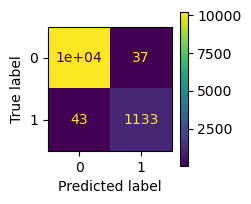

******** Resultados DatasetT1 ********
Accuracy: 99.36108929039015
Precision: 97.20181881776846
Recall: 96.42609299097849
F1-Score: 96.8124020205539
[[51361   160]
 [  206  5558]]


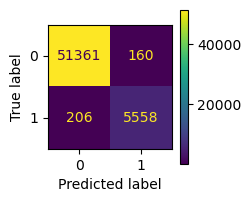

******** Resultados DatasetT2 ********
Accuracy: 99.29824561403508
Precision: 96.70731707317073
Recall: 96.30464954892436
F1-Score: 96.50556328233658
[[51332   189]
 [  213  5551]]


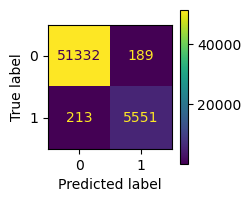

******** Resultados DatasetT3 ********
Accuracy: 99.41345902068605
Precision: 97.21642310368824
Recall: 96.94656488549617
F1-Score: 97.0813064628214
[[51361   160]
 [  176  5588]]


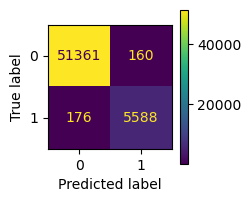

In [6]:
# Árvore de decisão final
#final_decision_tree_1 = dtTries.best_estimator_

final_decision_tree_1 = DecisionTreeClassifier(criterion = 'entropy', 
                                            max_depth = 16, 
                                            max_features = 3, 
                                            max_leaf_nodes = 270, 
                                            min_samples_leaf = 3, 
                                            min_samples_split = 6,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')

# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2)

final_decision_tree_1.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_1.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)
finalClassificationReport = classification_report(outputsTest, predicted_apply_brakes)

plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 100
# Plot da árvore de decisão treinada, comentado para diminuir tempo de execução
# plot_tree(final_decision_tree)
# plt.show()

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

# Testes para DatasetT1, DatasetT2 e DatasetT3
automatic_test(1,final_decision_tree_1)
automatic_test(2,final_decision_tree_1)
automatic_test(3,final_decision_tree_1)

In [53]:
# Teste para dataset sem ruído 
dataColumns = ['Distancia Ruidosa', 'Velocidade Ruidosa', 'Capacidade de Frenagem Ruidosa', 'Distancia', 'Velocidade', 
                'Capacidade de Frenagem', 'Decisão', 'Aceleracao', 'AW', 'AG', 'VH', 'VC', 'V50', 'DS', 'Decisao Ruidosa', 
                'Aceleracao Ruidosa', 'AW Ruidosa', 'AG Ruidosa', 'VH Ruidosa', 'VC Ruidosa', 'V50 Ruidosa', 'DS Ruidosa']
    
pp_dataset_test = pd.read_csv("DatasetT&VDebug.csv", header = None, names = dataColumns)

pp_data_inputs_test = pp_dataset_test[['Distancia', 'Velocidade', 'Capacidade de Frenagem']]
pp_data_inputs_test = pp_data_inputs_test.rename(columns={"Distancia":"Distância Ruidosa","Velocidade":"Velocidade Ruidosa", "Capacidade de Frenagem":"Capacidade de Frenagem Ruidosa"})

print(pp_data_inputs_test)

pp_data_outputs_test = pp_dataset_test[['Decisão']]

print(pp_data_outputs_test)



       Distância Ruidosa  Velocidade Ruidosa  Capacidade de Frenagem Ruidosa
0                    0.0                 0.0                          1.3950
1                    0.0                 0.0                          1.1625
2                    0.0                 0.0                          0.9300
3                    0.0                 0.0                          0.7800
4                    0.0                 0.0                          0.6500
...                  ...                 ...                             ...
57280             2000.0                28.0                          1.3950
57281             2000.0                28.0                          1.1625
57282             2000.0                28.0                          0.9300
57283             2000.0                28.0                          0.7800
57284             2000.0                28.0                          0.6500

[57285 rows x 3 columns]
       Decisão
0          1.0
1          1.0
2    

******** Resultados dataset sem ruido ********
Accuracy: 99.52692676966048
Precision: 97.64093668690373
Recall: 97.65787647467037
F1-Score: 97.64940584612717
[[51385   136]
 [  135  5629]]


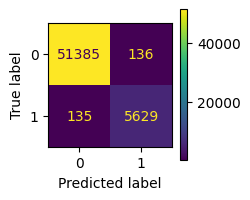

In [54]:
# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_1.predict(pp_data_inputs_test)

# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs_test, predicted_apply_brakes)
finalPrecision = precision_score(pp_data_outputs_test, predicted_apply_brakes)
finalRecall = recall_score(pp_data_outputs_test, predicted_apply_brakes)
finalF1 = f1_score(pp_data_outputs_test, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(pp_data_outputs_test, predicted_apply_brakes)
finalClassificationReport = classification_report(pp_data_outputs_test, predicted_apply_brakes)

# Imprime resultados finais
print(f'******** Resultados dataset sem ruido ********')
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()  

<h1>decision_tree_2</h1>

In [7]:
pp_dataset = pre_processing("DatasetT&V.csv")
pp_dataset = StratifyData(pp_dataset, 0.4, 0.8, 1, False) #Gera outro dataset, utilizando 40% do dataset original, com 80% das saídas iguais a 0
display(pp_dataset) # Note que shuffle = False, então temos diversos 1 no ínicio e os 0 nos fim

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs) #Entradas

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs) #Saídas

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Decisão
0,161.287901,26.676714,0.7800,1.0
1,219.200647,25.886505,1.1625,1.0
2,240.002120,16.531255,0.7800,1.0
3,10.809129,7.990000,0.6500,1.0
4,30.958756,26.606893,1.1625,1.0
...,...,...,...,...
22909,1310.548373,7.355368,0.7800,0.0
22910,1468.946790,18.285251,0.7800,0.0
22911,630.115465,5.714259,0.9300,0.0
22912,1860.334081,14.263234,0.6500,0.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,161.287901,26.676714,0.7800
1,219.200647,25.886505,1.1625
2,240.002120,16.531255,0.7800
3,10.809129,7.990000,0.6500
4,30.958756,26.606893,1.1625
...,...,...,...
22909,1310.548373,7.355368,0.7800
22910,1468.946790,18.285251,0.7800
22911,630.115465,5.714259,0.9300
22912,1860.334081,14.263234,0.6500


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
22909,0.0
22910,0.0
22911,0.0
22912,0.0


In [48]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(1, 22, step = 2)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [float(x) for x in np.linspace(0,0.5,5)] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500 

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

Número de combinações possíveis: 1520640
{'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random'], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'min_samples_split': [2, 5, 8, 11, 14, 17], 'min_samples_leaf': [1, 4, 7, 10, 13, 16], 'min_weight_fraction_leaf': [0.0, 0.125, 0.25, 0.375, 0.5], 'max_leaf_nodes': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, None], 'max_features': [1, 2, 3, 'log2', 'sqrt', None]}
Tempo estimado de processamento: 35.7 segundos


In [49]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)


Fitting 10 folds for each of 500 candidates, totalling 5000 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [1, 3, 5, 7, 9, 11, 13, 15,
                                                      17, 19, 21],
                                        'max_features': [1, 2, 3, 'log2',
                                                         'sqrt', None],
                                        'max_leaf_nodes': [200, 210, 220, 230,
                                                           240, 250, 260, 270,
                                                           280, 290, 300, 310,
                                                           320, 330, 340, 350,
                                                           360, 370, 380, 390,
                                                           400, 410, 420, 430,
                                                           440, 450, 460, 470,
                                                           480, 490, ...],
                                        'min_samples_leaf': [1, 4, 7, 10, 13,
                                                             16],
                                        'min_samples_split': [2, 5, 8, 11, 14,
                                                              17],
                                        'min_weight_fraction_leaf': [0.0, 0.125,
                                                                     0.25,
                                                                     0.375,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   scoring='recall', verbose=3)

In [50]:
print(dtTries.best_params_) 
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

{'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_leaf_nodes': 400, 'max_features': 3, 'max_depth': 7, 'criterion': 'entropy'}
10 - Fold Best recall-score:  97.9520863948127


In [60]:
# Segunda iteração

splitter = ['best']

min_weight_fraction_leaf = [0]

min_samples_split = [int(x) for x in np.arange(3, 8, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(2, 7, step = 1)]

max_leaf_nodes = [int(x) for x in np.arange(375, 430, step = 5)]

max_features = [1,2,3] 

max_depth = [int(x) for x in np.arange(5, 10, step = 1)]

criterion = ['entropy']

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

{'criterion': ['entropy'], 'splitter': ['best'], 'max_depth': [5, 6, 7, 8, 9], 'min_samples_split': [3, 4, 5, 6, 7], 'min_samples_leaf': [2, 3, 4, 5, 6], 'min_weight_fraction_leaf': [0], 'max_leaf_nodes': [375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425], 'max_features': [1, 2, 3]}


In [54]:
# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

Fitting 10 folds for each of 4125 candidates, totalling 41250 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [5, 6, 7, 8, 9],
                         'max_features': [1, 2, 3],
                         'max_leaf_nodes': [375, 380, 385, 390, 395, 400, 405,
                                            410, 415, 420, 425],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'min_weight_fraction_leaf': [0],
                         'splitter': ['best']},
             scoring='recall', verbose=3)

In [55]:
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

{'criterion': 'entropy', 'max_depth': 9, 'max_features': 3, 'max_leaf_nodes': 390, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}
10 - Fold Best recall-score:  98.07576543841833


<h2>final_decision_tree_2</h2>

Accuracy: 98.66899410866245
Precision: 96.46408839779006
Recall: 96.7849223946785
F1-Score: 96.62423907028224
[[3649   32]
 [  29  873]]


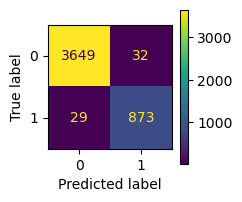

******** Resultados DatasetT1 ********
Accuracy: 99.03115998952605
Precision: 93.30008312551954
Recall: 97.36294240111035
F1-Score: 95.28822480685967
[[51118   403]
 [  152  5612]]


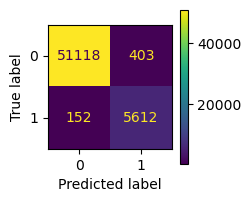

******** Resultados DatasetT2 ********
Accuracy: 98.97704460155363
Precision: 93.02093718843469
Recall: 97.12005551700209
F1-Score: 95.02631132235614
[[51101   420]
 [  166  5598]]


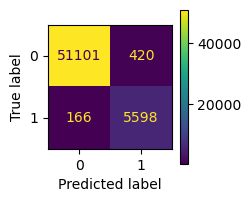

******** Resultados DatasetT3 ********
Accuracy: 99.0398882779087
Precision: 93.2625290408231
Recall: 97.50173490631506
F1-Score: 95.33502968617472
[[51115   406]
 [  144  5620]]


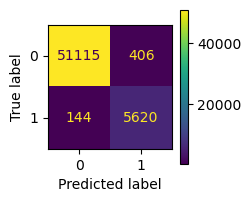

In [8]:
#final_decision_tree_2 = dtTries.best_estimator_

final_decision_tree_2 = DecisionTreeClassifier(criterion = 'entropy', 
                                            max_depth = 9, 
                                            max_features = 3, 
                                            max_leaf_nodes = 390, 
                                            min_samples_leaf = 3, 
                                            min_samples_split = 3,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')

# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2) # 20% dos dados para teste, com 50% das saídas sendo 0

final_decision_tree_2.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_2.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

automatic_test(1, final_decision_tree_2)
automatic_test(2, final_decision_tree_2)
automatic_test(3, final_decision_tree_2)

In [62]:
# Teste para dataset sem ruído 
dataColumns = ['Distancia Ruidosa', 'Velocidade Ruidosa', 'Capacidade de Frenagem Ruidosa', 'Distancia', 'Velocidade', 
                'Capacidade de Frenagem', 'Decisão', 'Aceleracao', 'AW', 'AG', 'VH', 'VC', 'V50', 'DS', 'Decisao Ruidosa', 
                'Aceleracao Ruidosa', 'AW Ruidosa', 'AG Ruidosa', 'VH Ruidosa', 'VC Ruidosa', 'V50 Ruidosa', 'DS Ruidosa']
    
pp_dataset_test = pd.read_csv("DatasetT&VDebug.csv", header = None, names = dataColumns)

pp_data_inputs_test = pp_dataset_test[['Distancia', 'Velocidade', 'Capacidade de Frenagem']]
pp_data_inputs_test = pp_data_inputs_test.rename(columns={"Distancia":"Distância Ruidosa","Velocidade":"Velocidade Ruidosa", "Capacidade de Frenagem":"Capacidade de Frenagem Ruidosa"})

print(pp_data_inputs_test)

pp_data_outputs_test = pp_dataset_test[['Decisão']]

print(pp_data_outputs_test)


       Distância Ruidosa  Velocidade Ruidosa  Capacidade de Frenagem Ruidosa
0                    0.0                 0.0                          1.3950
1                    0.0                 0.0                          1.1625
2                    0.0                 0.0                          0.9300
3                    0.0                 0.0                          0.7800
4                    0.0                 0.0                          0.6500
...                  ...                 ...                             ...
57280             2000.0                28.0                          1.3950
57281             2000.0                28.0                          1.1625
57282             2000.0                28.0                          0.9300
57283             2000.0                28.0                          0.7800
57284             2000.0                28.0                          0.6500

[57285 rows x 3 columns]
       Decisão
0          1.0
1          1.0
2    

******** Resultados dataset sem ruido ********
Accuracy: 99.15510168455965
Precision: 93.52126607319485
Recall: 98.42123525329633
F1-Score: 95.90870667793745
[[51128   393]
 [   91  5673]]


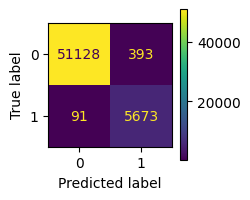

In [63]:
# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_2.predict(pp_data_inputs_test)

# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs_test, predicted_apply_brakes)
finalPrecision = precision_score(pp_data_outputs_test, predicted_apply_brakes)
finalRecall = recall_score(pp_data_outputs_test, predicted_apply_brakes)
finalF1 = f1_score(pp_data_outputs_test, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(pp_data_outputs_test, predicted_apply_brakes)
finalClassificationReport = classification_report(pp_data_outputs_test, predicted_apply_brakes)

# Imprime resultados finais
print(f'******** Resultados dataset sem ruido ********')
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()  

<h1>decision_tree_3</h1>

In [9]:
pp_dataset = pre_processing("DatasetStratifiedEmpty80.csv")
display(pp_dataset) # Note que shuffle = False, então temos diversos 1 no ínicio e os 0 nos fim

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs) #Entradas

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs) #Saídas

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Decisão
0,1952.847220,20.909488,0.650,0.0
1,1392.041071,13.252557,1.395,0.0
2,250.362430,5.478583,1.395,0.0
3,330.876991,10.939233,1.395,0.0
4,1006.760000,27.898820,0.930,0.0
...,...,...,...,...
57280,213.240000,0.517827,1.395,0.0
57281,1961.269368,3.423608,0.930,0.0
57282,1127.673681,23.287613,0.930,0.0
57283,1500.882320,11.057596,1.395,0.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,1952.847220,20.909488,0.650
1,1392.041071,13.252557,1.395
2,250.362430,5.478583,1.395
3,330.876991,10.939233,1.395
4,1006.760000,27.898820,0.930
...,...,...,...
57280,213.240000,0.517827,1.395
57281,1961.269368,3.423608,0.930
57282,1127.673681,23.287613,0.930
57283,1500.882320,11.057596,1.395


,Decisão
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


In [25]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(1, 22, step = 2)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [float(x) for x in np.linspace(0,0.5,5)] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500 

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

Número de combinações possíveis: 1520640
{'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random'], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'min_samples_split': [2, 5, 8, 11, 14, 17], 'min_samples_leaf': [1, 4, 7, 10, 13, 16], 'min_weight_fraction_leaf': [0.0, 0.125, 0.25, 0.375, 0.5], 'max_leaf_nodes': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, None], 'max_features': [1, 2, 3, 'log2', 'sqrt', None]}
Tempo estimado de processamento: 35.7 segundos


In [104]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [1, 3, 5, 7, 9, 11, 13, 15,
                                                      17, 19, 21],
                                        'max_features': [1, 2, 3, 'log2',
                                                         'sqrt', None],
                                        'max_leaf_nodes': [200, 210, 220, 230,
                                                           240, 250, 260, 270,
                                                           280, 290, 300, 310,
                                                           320, 330, 340, 350,
                                                           360, 370, 380, 390,
                                                           400, 410, 420, 430,
                                                           440, 450, 460, 470,
                                                           480, 490, ...],
                                        'min_samples_leaf': [1, 4, 7, 10, 13,
                                                             16],
                                        'min_samples_split': [2, 5, 8, 11, 14,
                                                              17],
                                        'min_weight_fraction_leaf': [0.0, 0.125,
                                                                     0.25,
                                                                     0.375,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   scoring='recall', verbose=3)

In [106]:
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

{'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_leaf_nodes': 400, 'max_features': None, 'max_depth': 13, 'criterion': 'entropy'}
10 - Fold Best recall-score:  96.96974319607543


In [107]:
# Segunda iteração

splitter = ['best']

min_weight_fraction_leaf = [0]

min_samples_split = [int(x) for x in np.arange(12, 17, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(1, 4, step = 1)]

max_leaf_nodes = [int(x) for x in np.arange(375, 430, step = 5)]

max_features = [None] 

max_depth = [int(x) for x in np.arange(11, 16, step = 1)]

criterion = ['entropy']

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

{'criterion': ['entropy'], 'splitter': ['best'], 'max_depth': [11, 12, 13, 14, 15], 'min_samples_split': [12, 13, 14, 15, 16], 'min_samples_leaf': [1, 2, 3], 'min_weight_fraction_leaf': [0], 'max_leaf_nodes': [375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425], 'max_features': [None]}


In [108]:
# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

Fitting 10 folds for each of 825 candidates, totalling 8250 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'],
                         'max_depth': [11, 12, 13, 14, 15],
                         'max_features': [None],
                         'max_leaf_nodes': [375, 380, 385, 390, 395, 400, 405,
                                            410, 415, 420, 425],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [12, 13, 14, 15, 16],
                         'min_weight_fraction_leaf': [0],
                         'splitter': ['best']},
             scoring='recall', verbose=3)

In [109]:
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

{'criterion': 'entropy', 'max_depth': 11, 'max_features': None, 'max_leaf_nodes': 375, 'min_samples_leaf': 1, 'min_samples_split': 13, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}
10 - Fold Best recall-score:  96.91386633843359


<h2>final_decision_tree_3</h2>

Accuracy: 99.24936719909225
Precision: 98.29470922606033
Recall: 97.9520697167756
F1-Score: 98.1230903535574
[[9123   39]
 [  47 2248]]


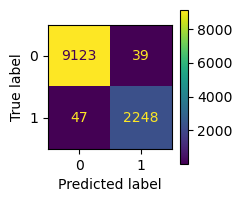

******** Resultados DatasetT1 ********
Accuracy: 99.32443047918304
Precision: 95.74612897736941
Recall: 97.6231783483692
F1-Score: 96.67554333820118
[[51271   250]
 [  137  5627]]


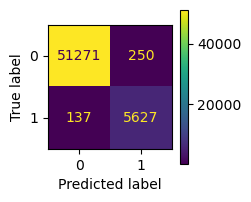

******** Resultados DatasetT2 ********
Accuracy: 99.30348258706468
Precision: 95.5201086034278
Recall: 97.65787647467037
F1-Score: 96.57716393583254
[[51257   264]
 [  135  5629]]


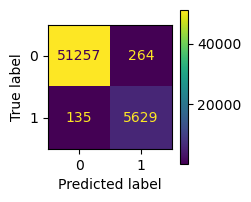

******** Resultados DatasetT3 ********
Accuracy: 99.28428035262286
Precision: 95.40366350067842
Recall: 97.58848022206801
F1-Score: 96.48370497427102
[[51250   271]
 [  139  5625]]


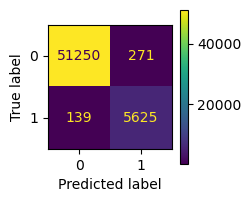

In [10]:
#final_decision_tree_3 = dtTries.best_estimator_

final_decision_tree_3 = DecisionTreeClassifier(criterion = 'entropy', 
                                            max_depth = 11, 
                                            max_features = None, 
                                            max_leaf_nodes = 375, 
                                            min_samples_leaf = 1, 
                                            min_samples_split = 13,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')

# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2) # 20% dos dados para teste, com 50% das saídas sendo 0

final_decision_tree_3.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_3.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

automatic_test(1, final_decision_tree_3)
automatic_test(2, final_decision_tree_3)
automatic_test(3, final_decision_tree_3)

In [76]:
# Teste para dataset sem ruído 
dataColumns = ['Distancia Ruidosa', 'Velocidade Ruidosa', 'Capacidade de Frenagem Ruidosa', 'Distancia', 'Velocidade', 
                'Capacidade de Frenagem', 'Decisão', 'Aceleracao', 'AW', 'AG', 'VH', 'VC', 'V50', 'DS', 'Decisao Ruidosa', 
                'Aceleracao Ruidosa', 'AW Ruidosa', 'AG Ruidosa', 'VH Ruidosa', 'VC Ruidosa', 'V50 Ruidosa', 'DS Ruidosa']
    
pp_dataset_test = pd.read_csv("DatasetT&VDebug.csv", header = None, names = dataColumns)

pp_data_inputs_test = pp_dataset_test[['Distancia', 'Velocidade', 'Capacidade de Frenagem']]
pp_data_inputs_test = pp_data_inputs_test.rename(columns={"Distancia":"Distância Ruidosa","Velocidade":"Velocidade Ruidosa", "Capacidade de Frenagem":"Capacidade de Frenagem Ruidosa"})

print(pp_data_inputs_test)

pp_data_outputs_test = pp_dataset_test[['Decisão']]

print(pp_data_outputs_test)

       Distância Ruidosa  Velocidade Ruidosa  Capacidade de Frenagem Ruidosa
0                    0.0                 0.0                          1.3950
1                    0.0                 0.0                          1.1625
2                    0.0                 0.0                          0.9300
3                    0.0                 0.0                          0.7800
4                    0.0                 0.0                          0.6500
...                  ...                 ...                             ...
57280             2000.0                28.0                          1.3950
57281             2000.0                28.0                          1.1625
57282             2000.0                28.0                          0.9300
57283             2000.0                28.0                          0.7800
57284             2000.0                28.0                          0.6500

[57285 rows x 3 columns]
       Decisão
0          1.0
1          1.0
2    

******** Resultados dataset sem ruido ********
Accuracy: 99.4815396700707
Precision: 96.25994246065324
Recall: 98.68147120055517
F1-Score: 97.45566692367001
[[51300   221]
 [   76  5688]]


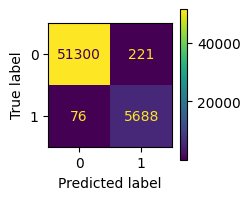

In [77]:
# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_3.predict(pp_data_inputs_test)

# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs_test, predicted_apply_brakes)
finalPrecision = precision_score(pp_data_outputs_test, predicted_apply_brakes)
finalRecall = recall_score(pp_data_outputs_test, predicted_apply_brakes)
finalF1 = f1_score(pp_data_outputs_test, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(pp_data_outputs_test, predicted_apply_brakes)
finalClassificationReport = classification_report(pp_data_outputs_test, predicted_apply_brakes)

# Imprime resultados finais
print(f'******** Resultados dataset sem ruido ********')
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()  

<h1>decision_tree_4</h1>

In [11]:
pp_dataset = pre_processing("DatasetStratifiedEmpty.csv")

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs) #Entradas

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs) #Saídas

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,61.616446,20.157099,1.1625
1,1488.727549,21.909256,0.9300
2,556.760000,17.894218,1.1625
3,67.904888,21.150000,1.3950
4,218.819664,23.689675,0.6500
...,...,...,...
57280,1368.806441,14.807434,0.6500
57281,1211.431628,17.866394,0.6500
57282,150.241098,24.380000,1.1625
57283,1023.240000,12.821036,0.9300


,Decisão
0,1.0
1,0.0
2,0.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,1.0
57283,0.0


In [80]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(1, 22, step = 2)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [float(x) for x in np.linspace(0,0.5,5)] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

Número de combinações possíveis: 1520640
{'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random'], 'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21], 'min_samples_split': [2, 5, 8, 11, 14, 17], 'min_samples_leaf': [1, 4, 7, 10, 13, 16], 'min_weight_fraction_leaf': [0.0, 0.125, 0.25, 0.375, 0.5], 'max_leaf_nodes': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, None], 'max_features': [1, 2, 3, 'log2', 'sqrt', None]}
Tempo estimado de processamento: 178.6 segundos


In [13]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

Fitting 10 folds for each of 2500 candidates, totalling 25000 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=2500, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [1, 3, 5, 7, 9, 11, 13, 15,
                                                      17, 19, 21],
                                        'max_features': [1, 2, 3, 'log2',
                                                         'sqrt', None],
                                        'max_leaf_nodes': [200, 210, 220, 230,
                                                           240, 250, 260, 270,
                                                           280, 290, 300, 310,
                                                           320, 330, 340, 350,
                                                           360, 370, 380, 390,
                                                           400, 410, 420, 430,
                                                           440, 450, 460, 470,
                                                           480, 490, ...],
                                        'min_samples_leaf': [1, 4, 7, 10, 13,
                                                             16],
                                        'min_samples_split': [2, 5, 8, 11, 14,
                                                              17],
                                        'min_weight_fraction_leaf': [0.0, 0.125,
                                                                     0.25,
                                                                     0.375,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   scoring='recall', verbose=3)

In [14]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

{'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_leaf_nodes': 340, 'max_features': None, 'max_depth': 3, 'criterion': 'entropy'}
10 - Fold Best recall-score:  99.6866217747907


In [21]:
# Segunda iteração

splitter = ['best']

min_weight_fraction_leaf = [0]

min_samples_split = [int(x) for x in np.arange(3, 8, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(7, 14, step = 1)]

max_leaf_nodes = [int(x) for x in np.arange(320, 365, step = 5)]

max_features = [None] 

max_depth = [int(x) for x in np.arange(1, 5, step = 1)]

criterion = ['entropy']

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

{'criterion': ['entropy'], 'splitter': ['best'], 'max_depth': [1, 2, 3, 4], 'min_samples_split': [3, 4, 5, 6, 7], 'min_samples_leaf': [7, 8, 9, 10, 11, 12, 13], 'min_weight_fraction_leaf': [0], 'max_leaf_nodes': [320, 325, 330, 335, 340, 345, 350, 355, 360], 'max_features': [None]}


In [22]:
# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

Fitting 10 folds for each of 1260 candidates, totalling 12600 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [1, 2, 3, 4],
                         'max_features': [None],
                         'max_leaf_nodes': [320, 325, 330, 335, 340, 345, 350,
                                            355, 360],
                         'min_samples_leaf': [7, 8, 9, 10, 11, 12, 13],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'min_weight_fraction_leaf': [0],
                         'splitter': ['best']},
             scoring='recall', verbose=3)

In [23]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

{'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': 320, 'min_samples_leaf': 7, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}
10 - Fold Best recall-score:  99.7280120760091


<h2>final_decision_tree_4</h2>

Accuracy: 95.2518111198394
Precision: 91.59541861590579
Recall: 99.59656200666551
F1-Score: 95.42857142857143
[[5235  521]
 [  23 5678]]


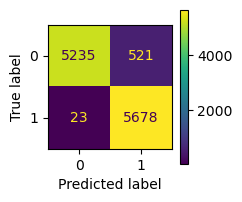

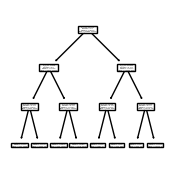

******** Resultados DatasetT1 ********
Accuracy: 92.00139652614122
Precision: 55.7367501456028
Recall: 99.61832061068702
F1-Score: 71.48014440433214
[[46961  4560]
 [   22  5742]]


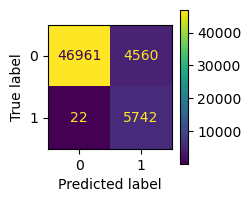

******** Resultados DatasetT2 ********
Accuracy: 92.00837915684734
Precision: 55.753929749660394
Recall: 99.68771686328938
F1-Score: 71.51213441194773
[[46961  4560]
 [   18  5746]]


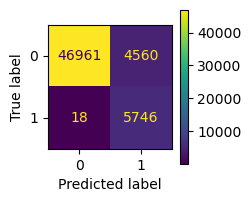

******** Resultados DatasetT3 ********
Accuracy: 91.97870297634634
Precision: 55.66321092917354
Recall: 99.67036780013879
F1-Score: 71.43301212309605
[[46945  4576]
 [   19  5745]]


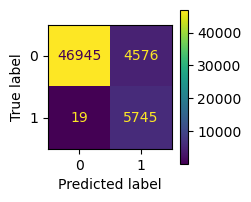

In [12]:
#final_decision_tree_4 = dtTries.best_estimator_

final_decision_tree_4 = DecisionTreeClassifier(criterion = 'entropy', 
                                            max_depth = 3, 
                                            max_features = None, 
                                            max_leaf_nodes = 320, 
                                            min_samples_leaf = 7, 
                                            min_samples_split = 33,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')


# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2) # 20% dos dados para teste, com 50% das saídas sendo 0

final_decision_tree_4.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_4.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 100
plot_tree(final_decision_tree_4)
plt.show()  

automatic_test(1, final_decision_tree_4)
automatic_test(2, final_decision_tree_4)
automatic_test(3, final_decision_tree_4)

<h1>decision_tree_5</h1>

In [13]:
pp_dataset = pre_processing("DatasetT&V.csv")

pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.000000,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,1.579846,0.000000,0.9300
3,0.282185,0.000000,0.7800
4,0.394876,0.000000,0.6500
...,...,...,...
57280,2000.433820,26.977928,1.3950
57281,1999.988138,28.886308,1.1625
57282,1998.246886,28.409583,0.9300
57283,2002.044078,27.358991,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


In [23]:
random_state = 3

# Definição dos hiperparâmetros

criterion = ['entropy', 'gini']

splitter = ['best', 'random']

max_depth = [int(x) for x in np.arange(9, 15, step = 2)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 18, step = 3)]

min_samples_leaf = [int(x) for x in np.arange(1, 18, step = 3)]

min_weight_fraction_leaf = [float(x) for x in np.linspace(0,0.5,5)] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(200, 510, step = 10)]
max_leaf_nodes.append(None)

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 
max_features.append('log2')
max_features.append('sqrt')
max_features.append(None)

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

Número de combinações possíveis: 414720
{'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random'], 'max_depth': [9, 11, 13], 'min_samples_split': [2, 5, 8, 11, 14, 17], 'min_samples_leaf': [1, 4, 7, 10, 13, 16], 'min_weight_fraction_leaf': [0.0, 0.125, 0.25, 0.375, 0.5], 'max_leaf_nodes': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, None], 'max_features': [1, 2, 3, 'log2', 'sqrt', None]}
Tempo estimado de processamento: 178.6 segundos


In [24]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com RandomSearch
dtTries = RandomizedSearchCV(estimator = starting_decision_tree, param_distributions = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1, n_iter = n_iter)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

Fitting 10 folds for each of 2500 candidates, totalling 25000 fits


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   estimator=DecisionTreeClassifier(), n_iter=2500, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [9, 11, 13],
                                        'max_features': [1, 2, 3, 'log2',
                                                         'sqrt', None],
                                        'max_leaf_nodes': [200, 210, 220, 230,
                                                           240, 250, 260, 270,
                                                           280, 290, 300, 310,
                                                           320, 330, 340, 350,
                                                           360, 370, 380, 390,
                                                           400, 410, 420, 430,
                                                           440, 450, 460, 470,
                                                           480, 490, ...],
                                        'min_samples_leaf': [1, 4, 7, 10, 13,
                                                             16],
                                        'min_samples_split': [2, 5, 8, 11, 14,
                                                              17],
                                        'min_weight_fraction_leaf': [0.0, 0.125,
                                                                     0.25,
                                                                     0.375,
                                                                     0.5],
                                        'splitter': ['best', 'random']},
                   scoring='recall', verbose=3)

In [26]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

{'splitter': 'best', 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_leaf_nodes': 430, 'max_features': 3, 'max_depth': 11, 'criterion': 'entropy'}
10 - Fold Best recall-score:  96.44122712700083


In [27]:
random_state = 1

# Definição dos hiperparâmetros

criterion = ['entropy']

splitter = ['best']

max_depth = [int(x) for x in np.arange(9, 15, step = 1)] # max_depth já foi limitado

min_samples_split = [int(x) for x in np.arange(2, 9, step = 1)]

min_samples_leaf = [int(x) for x in np.arange(1, 4, step = 1)]

min_weight_fraction_leaf = [0] # Ajustado o intervalo, o peso máximo aceito é 0.5, entretanto todas as RSearch dão 0

max_leaf_nodes = [int(x) for x in np.arange(390, 480, step = 10)]

max_features = [int(x) for x in np.arange(1, 4, step = 1)] 

combinations = len(criterion)*len(splitter)*len(max_depth)*len(min_samples_leaf)*len(min_samples_split)*len(min_weight_fraction_leaf)*len(max_leaf_nodes)*len(max_features)

print('Número de combinações possíveis:', combinations)

hyperparameters_settings = {'criterion'                : criterion,
                            'splitter'                 : splitter,
                            'max_depth'                : max_depth,
                            'min_samples_split'        : min_samples_split,
                            'min_samples_leaf'         : min_samples_leaf,
                            'min_weight_fraction_leaf' : min_weight_fraction_leaf,
                            'max_leaf_nodes'           : max_leaf_nodes,
                            'max_features'             : max_features
                           }

print(hyperparameters_settings)

# Metrica de performance
scoring = 'recall'

# Número de partições
k_fold = 10 

# Número de iterações
n_iter = 2500

print('Tempo estimado de processamento:', round((n_iter*10)/140,1), 'segundos')

Número de combinações possíveis: 3402
{'criterion': ['entropy'], 'splitter': ['best'], 'max_depth': [9, 10, 11, 12, 13, 14], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8], 'min_samples_leaf': [1, 2, 3], 'min_weight_fraction_leaf': [0], 'max_leaf_nodes': [390, 400, 410, 420, 430, 440, 450, 460, 470], 'max_features': [1, 2, 3]}
Tempo estimado de processamento: 178.6 segundos


In [28]:
# Criação da árvore de decisão
starting_decision_tree = DecisionTreeClassifier()

# Optimização dos hiperparâmetros com GridSearch
dtTries = GridSearchCV(estimator = starting_decision_tree, param_grid = hyperparameters_settings, scoring = scoring,
                            cv = KFold(n_splits = k_fold, shuffle = True), verbose = 3, n_jobs = -1)

# Teste com os hiperparâmetros encontrados
dtTries.fit(pp_data_inputs, pp_data_outputs)

Fitting 10 folds for each of 3402 candidates, totalling 34020 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'],
                         'max_depth': [9, 10, 11, 12, 13, 14],
                         'max_features': [1, 2, 3],
                         'max_leaf_nodes': [390, 400, 410, 420, 430, 440, 450,
                                            460, 470],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
                         'min_weight_fraction_leaf': [0],
                         'splitter': ['best']},
             scoring='recall', verbose=3)

In [29]:
# Imprime valores ótimos dos hiperparâmetros
print(dtTries.best_params_)
print(k_fold,'- Fold Best recall-score: ', dtTries.best_score_*100)

{'criterion': 'entropy', 'max_depth': 13, 'max_features': 2, 'max_leaf_nodes': 470, 'min_samples_leaf': 3, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}
10 - Fold Best recall-score:  96.47316879650599


<h2>final_decision_tree_5</h2>

Accuracy: 99.24936719909225
Precision: 96.58048373644704
Recall: 96.25935162094763
F1-Score: 96.41965029142382
[[10213    41]
 [   45  1158]]


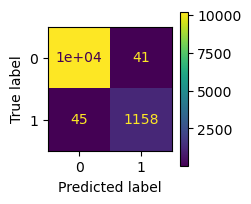

******** Resultados DatasetT1 ********
Accuracy: 99.32093916382996
Precision: 96.61751951431049
Recall: 96.63428174878557
F1-Score: 96.62589990458842
[[51326   195]
 [  194  5570]]


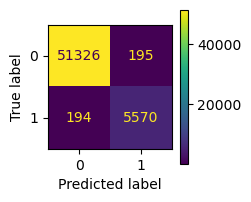

******** Resultados DatasetT2 ********
Accuracy: 99.29126298332896
Precision: 96.51041666666667
Recall: 96.44344205412908
F1-Score: 96.47691773689692
[[51320   201]
 [  205  5559]]


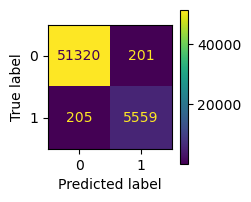

******** Resultados DatasetT3 ********
Accuracy: 99.34363271362486
Precision: 96.65742985798407
Recall: 96.82512144344206
F1-Score: 96.74120298145257
[[51328   193]
 [  183  5581]]


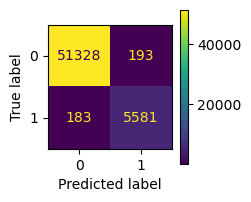

In [14]:
#final_decision_tree_5 = dtTries.best_estimator_

final_decision_tree_5 = DecisionTreeClassifier(criterion = 'entropy', 
                                            max_depth = 13, 
                                            max_features = 2, 
                                            max_leaf_nodes = 470, 
                                            min_samples_leaf = 3, 
                                            min_samples_split = 4,
                                            min_weight_fraction_leaf = 0, 
                                            splitter = 'best')


# Holdout test
inputsTrain, inputsTest, outputsTrain, outputsTest = train_test_split(pp_data_inputs, 
                                                                      pp_data_outputs,
                                                                      test_size = 0.2) # 20% dos dados para teste, com 50% das saídas sendo 0

final_decision_tree_5.fit(inputsTrain, outputsTrain)

# Valores preditos pela árvore treinada
predicted_apply_brakes = final_decision_tree_5.predict(inputsTest)

# Métricas de performance
finalAccuracy = accuracy_score(outputsTest, predicted_apply_brakes)
finalPrecision = precision_score(outputsTest, predicted_apply_brakes)
finalRecall = recall_score(outputsTest, predicted_apply_brakes)
finalF1 = f1_score(outputsTest, predicted_apply_brakes)
finalConfusionMatrix = confusion_matrix(outputsTest, predicted_apply_brakes)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

plt.rcParams['figure.figsize'] = [2, 2]
plt.rcParams['figure.dpi'] = 100

automatic_test(1, final_decision_tree_5)
automatic_test(2, final_decision_tree_5)
automatic_test(3, final_decision_tree_5)

<h1>voting</h1>

In [15]:
# Realiza a leitura do arquivo CSV
# O arquivo se encontra numa pasta dentro do diretório deste programa:
# ./Árvore de Decisão/Dataset/Dataset.csv
pp_dataset = pre_processing("DatasetT3.csv")
print(pp_dataset)

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
print(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
print(pp_data_outputs)

       Distância Ruidosa  Velocidade Ruidosa  Capacidade de Frenagem Ruidosa  \
0               0.504450            0.000000                          1.3950   
1               0.000000            0.000000                          1.1625   
2               0.000000            0.000000                          0.9300   
3               1.158221            0.000000                          0.7800   
4               0.156073            0.000000                          0.6500   
...                  ...                 ...                             ...   
57280        1998.864111           26.913394                          1.3950   
57281        1998.304338           27.914276                          1.1625   
57282        1999.635227           27.073422                          0.9300   
57283        1999.776292           27.574239                          0.7800   
57284        1999.379985           28.009829                          0.6500   

       Decisão  
0          1.0  
1    

<h2> using max_depth = 16</h2>

In [16]:
decision_trees = [final_decision_tree_1, final_decision_tree_3, final_decision_tree_4]

final_prediction = voting("DatasetT3.csv", decision_trees)

Accuracy: 99.34537837130138
Precision: 94.75170237502077
Recall: 98.9764052741152
F1-Score: 96.81798896902843
[[51205   316]
 [   59  5705]]


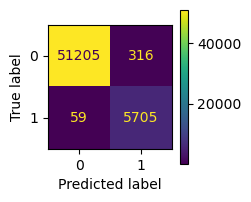

In [17]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_prediction)
finalPrecision = precision_score(pp_data_outputs, final_prediction)
finalRecall = recall_score(pp_data_outputs, final_prediction)
finalF1 = f1_score(pp_data_outputs, final_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_prediction)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

<h2> using max_depth = 13</h2>

In [18]:
decision_trees = [final_decision_tree_5, final_decision_tree_3, final_decision_tree_4]

final_prediction = voting("DatasetT3.csv", decision_trees)

Accuracy: 99.29999127171162
Precision: 94.49145511863281
Recall: 98.8029146426093
F1-Score: 96.59910100924434
[[51189   332]
 [   69  5695]]


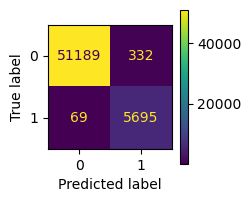

In [19]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_prediction)
finalPrecision = precision_score(pp_data_outputs, final_prediction)
finalRecall = recall_score(pp_data_outputs, final_prediction)
finalF1 = f1_score(pp_data_outputs, final_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_prediction)

# Imprime resultados finais
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

<h1>conifer</h1>

In [20]:
import conifer
import datetime
import logging
import sys
from conifer.converters.sklearn import convert

In [21]:
#Função responsável por criar uma floresta aleatória utilizando uma lista de árvores de decisão
def convert_tree_to_random_forest(dt_arr, rf):
    depths = [tree.max_depth for tree in dt_arr]
    features = [tree.n_features_in_ for tree in dt_arr]
    classes = [tree.n_classes_ for tree in dt_arr]
    rf.max_depth = int(max(depths))
    rf.n_estimators = len(dt_arr)
    rf.n_features_in_ = int(max(features))
    rf.n_classes_ = int(max(classes))
    for i in range(len(dt_arr)):
        rf.estimators_[i] = dt_arr[i]
    return rf

In [22]:
pp_dataset = pre_processing("DatasetT&V.csv")
display(pp_dataset)

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Decisão
0,0.000000,0.000000,1.3950,1.0
1,0.000000,0.000000,1.1625,1.0
2,1.579846,0.000000,0.9300,1.0
3,0.282185,0.000000,0.7800,1.0
4,0.394876,0.000000,0.6500,1.0
...,...,...,...,...
57280,2000.433820,26.977928,1.3950,0.0
57281,1999.988138,28.886308,1.1625,0.0
57282,1998.246886,28.409583,0.9300,0.0
57283,2002.044078,27.358991,0.7800,0.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.000000,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,1.579846,0.000000,0.9300
3,0.282185,0.000000,0.7800
4,0.394876,0.000000,0.6500
...,...,...,...
57280,2000.433820,26.977928,1.3950
57281,1999.988138,28.886308,1.1625
57282,1998.246886,28.409583,0.9300
57283,2002.044078,27.358991,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


In [23]:
dtrees = [final_decision_tree_5, final_decision_tree_3, final_decision_tree_4] #Vetor de árvores de decisão

#Classificador dummy para pode utilizar a função conversora (apenas o número de estimadores deve ser compatível com o número de árvores na lista)
starting_random_forest = RandomForestClassifier(n_estimators=len(dtrees), max_depth=4, random_state=0).fit(inputsTrain, outputsTrain)

#Cria árvore de decisão utilizando os estimadores da lista
emsemble_decision_tree = convert_tree_to_random_forest(dtrees, starting_random_forest)

/tmp/ipykernel_3927/966513272.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  starting_random_forest = RandomForestClassifier(n_estimators=len(dtrees), max_depth=4, random_state=0).fit(inputsTrain, outputsTrain)


In [24]:
pp_dataset = pre_processing("DatasetT3.csv")
display(pp_dataset)

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Decisão
0,0.504450,0.000000,1.3950,1.0
1,0.000000,0.000000,1.1625,1.0
2,0.000000,0.000000,0.9300,1.0
3,1.158221,0.000000,0.7800,1.0
4,0.156073,0.000000,0.6500,1.0
...,...,...,...,...
57280,1998.864111,26.913394,1.3950,0.0
57281,1998.304338,27.914276,1.1625,0.0
57282,1999.635227,27.073422,0.9300,0.0
57283,1999.776292,27.574239,0.7800,0.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.504450,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,0.000000,0.000000,0.9300
3,1.158221,0.000000,0.7800
4,0.156073,0.000000,0.6500
...,...,...,...
57280,1998.864111,26.913394,1.3950
57281,1998.304338,27.914276,1.1625
57282,1999.635227,27.073422,0.9300
57283,1999.776292,27.574239,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


In [25]:
decision_trees = [final_decision_tree_5, final_decision_tree_3, final_decision_tree_4]

#Comparação entre votação da função criada e a floresta aleatória criada manualmente
#De forma geral a função "voting" apresenta melhor recall e menor precisão, as diferenças são pequenas em comparação com a floresta aleatória criada
final_prediction = voting("DatasetT3.csv", decision_trees)

final_emsemble_prediction = emsemble_decision_tree.predict(pp_data_inputs)

Resultado utilizando a função 'voting()'
Accuracy: 99.29999127171162
Precision: 94.49145511863281
Recall: 98.8029146426093
F1-Score: 96.59910100924434
[[51189   332]
 [   69  5695]]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fd7f0372d30>


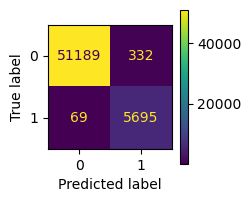

In [70]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_prediction)
finalPrecision = precision_score(pp_data_outputs, final_prediction)
finalRecall = recall_score(pp_data_outputs, final_prediction)
finalF1 = f1_score(pp_data_outputs, final_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_prediction)

# Imprime resultados finais
print("Resultado utilizando a função 'voting()'")
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

Resultado utilizando a floresta aleatória
Accuracy: 99.3226848215065
Precision: 94.78507164278574
Recall: 98.69882026370576
F1-Score: 96.7023627400986
[[51208   313]
 [   75  5689]]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fd7ef83d160>


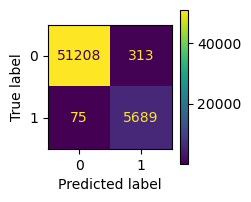

In [72]:
# Métricas de performance
finalAccuracy = accuracy_score(pp_data_outputs, final_emsemble_prediction)
finalPrecision = precision_score(pp_data_outputs, final_emsemble_prediction)
finalRecall = recall_score(pp_data_outputs, final_emsemble_prediction)
finalF1 = f1_score(pp_data_outputs, final_emsemble_prediction)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, final_emsemble_prediction)
finalClassificationReport = classification_report(pp_data_outputs, final_emsemble_prediction)

# Imprime resultados finais
print("Resultado utilizando a floresta aleatória")
print('Accuracy:', finalAccuracy*100)
print('Precision:', finalPrecision*100)
print('Recall:', finalRecall*100)
print('F1-Score:', finalF1*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

In [28]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# Conifer Settings 
cfg = {'Backend' : 'vhdl',
              'ProjectName' : 'my-prj',
              'OutputDir'   : 'my-conifer-prj',
              'Precision'   : 'ap_fixed<19,12>', #exemplo: <18,12> -> 18 bits total, 12 para representar a parte inteira e 18 - 12 = 6 para representação decimal
              'XilinxPart' : 'xc7s100',
              'ClockPeriod' : '5'}

# Set the output directory to something unique
cfg['OutputDir'] = 'prj_{}'.format("emsemble<18,12>")

In [29]:
# Create and compile the model
model = conifer.converters.convert_from_sklearn(emsemble_decision_tree, cfg)

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 13, "n_trees": 3, "n_features": 3, "n_classes": 2}


In [30]:
#Compila modelo 
model.compile()

INFO:conifer.model:Saving model to prj_emsemble<18,12>
INFO:conifer.backends.vhdl.writer:Writing project to prj_emsemble<18,12>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"


In [31]:
pp_dataset = pre_processing("DatasetT3.csv")
display(pp_dataset)

#Define as entradas e as saídas do dataset
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
display(pp_data_inputs)

pp_data_outputs = pp_dataset[['Decisão']]
display(pp_data_outputs)

pp_data_inputs = pp_data_inputs.to_numpy(dtype=np.float32)

y_hdl = model.decision_function(pp_data_inputs) #Calcula a probabilidade da saída ser da classe A dado as entradas x, y, z (HDL)
y_skl = emsemble_decision_tree.predict_proba(pp_data_inputs) #Calcula a probabilidade da saída ser da classe A dado as entradas x, y, z (Sklearn)

,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Decisão
0,0.504450,0.000000,1.3950,1.0
1,0.000000,0.000000,1.1625,1.0
2,0.000000,0.000000,0.9300,1.0
3,1.158221,0.000000,0.7800,1.0
4,0.156073,0.000000,0.6500,1.0
...,...,...,...,...
57280,1998.864111,26.913394,1.3950,0.0
57281,1998.304338,27.914276,1.1625,0.0
57282,1999.635227,27.073422,0.9300,0.0
57283,1999.776292,27.574239,0.7800,0.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa
0,0.504450,0.000000,1.3950
1,0.000000,0.000000,1.1625
2,0.000000,0.000000,0.9300
3,1.158221,0.000000,0.7800
4,0.156073,0.000000,0.6500
...,...,...,...
57280,1998.864111,26.913394,1.3950
57281,1998.304338,27.914276,1.1625
57282,1999.635227,27.073422,0.9300
57283,1999.776292,27.574239,0.7800


,Decisão
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
57280,0.0
57281,0.0
57282,0.0
57283,0.0


INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 64 from ap_fixed<18,12>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy HDL: 99.30173692938816
Precision HDL: 94.56630109670986
Recall HDL: 98.73351839000694
[[51194   327]
 [   73  5691]]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fd7f4134700>


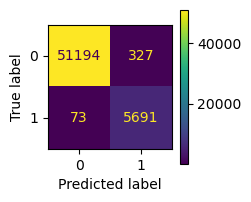

Accuracy SKL: 99.3226848215065
Precision SKL: 94.78507164278574
Recall SKL: 98.69882026370576
[[51208   313]
 [   75  5689]]
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x7fd7f41fbf10>


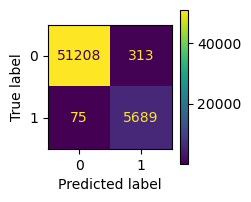

In [66]:
y_hdl_real = [1 if x <= 0.5 else 0 for x in y_hdl] #Retorna a classe (0 ou 1) dado sua probabilidade de acontecer
y_skl_real = emsemble_decision_tree.predict(pp_data_inputs)

finalAccuracy = accuracy_score(pp_data_outputs, y_hdl_real)
finalPrecision = precision_score(pp_data_outputs, y_hdl_real)
finalRecall = recall_score(pp_data_outputs, y_hdl_real)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, y_hdl_real)

print('Accuracy HDL:', finalAccuracy*100)
print('Precision HDL:', finalPrecision*100)
print('Recall HDL:', finalRecall*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

finalAccuracy = accuracy_score(pp_data_outputs, y_skl_real)
finalPrecision = precision_score(pp_data_outputs, y_skl_real)
finalRecall = recall_score(pp_data_outputs, y_skl_real)
finalConfusionMatrix = confusion_matrix(pp_data_outputs, y_skl_real)

print('Accuracy SKL:', finalAccuracy*100)
print('Precision SKL:', finalPrecision*100)
print('Recall SKL:', finalRecall*100)
print(finalConfusionMatrix)
ConfusionMatrixDisplay(finalConfusionMatrix).plot()
plt.show()

<h1>error_analysis</h1>

<h2>values and predictions error</h2>

In [69]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
#Retorna apenas a primeira coluna de probabilidades (segunda coluna é a prob complementar)
y_skl = emsemble_decision_tree.predict_proba(pp_data_inputs)
y_skl = [row[0] for row in y_skl]

#Calcula métricas
erro = abs(y_hdl - y_skl)
mean = mean_absolute_error(y_skl, y_hdl)
mse = mean_squared_error(y_skl, y_hdl, squared=True)
rmse = mean_squared_error(y_skl, y_hdl, squared=False)
std = np.std(erro)
q = 75
percentile = np.percentile(erro, q)

#Grava métricas em um arquivo .txt
original_stdout = sys.stdout
with open('Errors.txt', 'w') as f:
    sys.stdout = f
    print(f"mean absolute error = {mean*100}%")
    print(f"standard deviation = {std*100}%")
    print(f"mean squared error = {mse*100}%")
    print(f"root mean squared error = {rmse*100}%")
    print(f"error percentile {q}% = {percentile*100}%")
    sys.stdout = original_stdout 

print(f"mean absolute error = {mean*100}%")
print(f"standard deviation = {std*100}%")
print(f"mean squared error = {mse*100}%")
print(f"root mean squared error = {rmse*100}%")
print(f"error percentile {q}% = {percentile*100}%")    

counterVal = 0
counterPred = 0
row = np.zeros(7)

columns = ["Distância Ruidosa", "Velocidade Ruidosa", "Capacidade de Frenagem Ruidosa", "Prob SKL (%)", "Prob HDL (%)", "Erro absoluto (%)", "Index"]
errorvalues = []
errorprediction = []

for i in range(len(erro)):
    #Cria tabela com os casos onde o erro é maior que a média + desvio padrão
    if(erro[i] > mean + std):
        row[range(3)] = pp_data_inputs[i].tolist()
        row[range(3,7)] = [y_skl[i]*100, y_hdl[i]*100, erro[i]*100, int(i)]
        errorvalues.append(np.array(row))
        counterVal = counterVal + 1

    #Cria tabela com os casos onde o erro leva a uma predição incorreta  
    if((y_skl[i] <= 0.5 and y_hdl[i] >= 0.5) or ((y_skl[i] >= 0.5 and y_hdl[i] <= 0.5))):
        row[range(3)] = pp_data_inputs[i].tolist()
        row[range(3,7)]  = [y_skl[i]*100, y_hdl[i]*100, erro[i]*100, int(i)]
        errorprediction.append(np.array(row))
        counterPred = counterPred + 1

errorvalues = pd.DataFrame(errorvalues, columns = columns)
errorprediction = pd.DataFrame(errorprediction, columns = columns)

display(errorvalues)
display(errorprediction)

#Escreve planilha com os dataframes criados
with pd.ExcelWriter("ErrorAnalysis<18,12>.xlsx") as writer: 
    errorvalues.to_excel(writer, sheet_name = "Value Error", index = False)
    errorprediction.to_excel(writer, sheet_name = "Prediction Error", index = False)


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


mean absolute error = 1.3273513988954326%
standard deviation = 0.7530164858595245%
mean squared error = 0.0232889556412589%
root mean squared error = 1.5260719393678301%
error percentile 75% = 1.5625%


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Prob SKL (%),Prob HDL (%),Erro absoluto(%),Index
0,67.865204,12.638085,1.1625,0.510815,4.6875,4.176685,2121.0
1,79.610054,9.042397,0.6500,10.672219,18.7500,8.077781,2374.0
2,99.759880,10.196367,0.9300,4.005552,15.6250,11.619448,2952.0
3,110.341232,9.741034,0.6500,70.672219,37.5000,33.172219,3234.0
4,110.534767,10.121746,0.7800,37.338886,48.4375,11.098614,3238.0
5,179.188751,14.087088,0.9300,24.584889,43.7500,19.165111,5272.0
6,199.088745,15.566207,0.7800,0.510815,21.8750,21.364185,5858.0
7,210.372589,18.575186,1.3950,36.621926,46.8750,10.253074,6170.0
8,209.216721,19.709930,0.9300,33.844148,0.0000,33.844148,6187.0
9,209.229507,24.702810,0.9300,0.510815,32.8125,32.301685,6232.0


,Distância Ruidosa,Velocidade Ruidosa,Capacidade de Frenagem Ruidosa,Prob SKL (%),Prob HDL (%),Erro absoluto(%),Index
0,110.341232,9.741034,0.6500,70.672219,37.5000,33.172219,3234.0
1,130.467636,11.410906,0.6500,49.300373,50.0000,0.699627,3824.0
2,127.474953,13.323026,1.3950,50.510815,50.0000,0.510815,3840.0
3,129.194580,13.513520,1.1625,50.510815,50.0000,0.510815,3841.0
4,140.139313,12.738292,1.3950,50.510815,50.0000,0.510815,4120.0
5,138.704300,12.999350,1.3950,50.510815,50.0000,0.510815,4125.0
6,138.735016,13.222921,1.1625,50.510815,50.0000,0.510815,4126.0
7,137.842789,14.137368,1.3950,50.510815,50.0000,0.510815,4130.0
8,260.372101,21.200180,1.3950,51.491207,50.0000,1.491207,7625.0
9,270.171021,21.031277,1.3950,51.491207,50.0000,1.491207,7905.0


<h2>ap_fixed_optimization</h2>

In [28]:
pp_dataset = pre_processing("DatasetT&V.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

In [29]:
starting_random_forest = RandomForestClassifier(n_estimators=2, max_depth=4, random_state=0).fit(inputsTrain, outputsTrain) #dummy classifier
dtrees = [final_decision_tree_3, final_decision_tree_4]
emsemble_decision_tree = convert_tree_to_random_forest(dtrees, starting_random_forest)

/tmp/ipykernel_5079/3522454067.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  starting_random_forest = RandomForestClassifier(n_estimators=2, max_depth=4, random_state=0).fit(inputsTrain, outputsTrain)


In [30]:
pp_dataset = pre_processing("DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

In [31]:
decision_trees = [final_decision_tree_3, final_decision_tree_4]
final_prediction = voting("DatasetT3.csv", decision_trees)
final_emsemble_prediction = emsemble_decision_tree.predict(pp_data_inputs)

In [32]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# Conifer Settings
cfg = {'Backend' : 'vhdl',
              'ProjectName' : 'my-prj',
              'OutputDir'   : 'my-conifer-prj',
              'Precision'   : 'ap_fixed<18,14>',
              'XilinxPart' : 'xc7s100',
              'ClockPeriod' : '5'}

# Set the output directory to something unique
cfg['OutputDir'] = 'prj_{}'.format(int(datetime.datetime.now().timestamp()))

In [34]:
#Os valores abaixo representam -> ap_fixed<left,right>
left = [18, 19, 20, 21, 22, 23, 24]
right = [8, 9, 10, 11, 12]
optimal_values = []

#Compila, simula e calcula o erro para cada combinação de ap_fixed<left,right>, se o erro (recall esperado e obtido) for inferior a 2%, escreve no vetor
for i in left:
    for j in right:
        cfg['Precision'] = f'ap_fixed<{i},{j}>' 
        cfg['OutputDir'] = 'prj_{}'.format(f'ap_fixed<{i},{j}>')

        model = conifer.converters.convert_from_sklearn(emsemble_decision_tree, cfg)
        model.compile()

        pp_dataset = pre_processing("DatasetT3.csv")
        pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
        pp_data_inputs = pp_data_inputs.to_numpy(dtype=np.float32)
        pp_data_outputs = pp_dataset[['Decisão']]

        y_hdl = model.decision_function(pp_data_inputs)
        y_skl = emsemble_decision_tree.predict_proba(pp_data_inputs)

        y_hdl_real = [1 if x < 0.5 else 0 for x in y_hdl]
        y_skl_real = emsemble_decision_tree.predict(pp_data_inputs)

        finalRecall_hdl = recall_score(pp_data_outputs, y_hdl_real)*100
        finalRecall_skl = recall_score(pp_data_outputs, y_skl_real)*100

        erro = abs(finalRecall_hdl - finalRecall_skl)

        if (erro < 2):
            optimal_values.append(f'ap_fixed<{i},{j}> | recall error = {erro} | recall expected = {finalRecall_skl}')
            print(optimal_values)

DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}
INFO:conifer.model:Saving model to prj_ap_fixed<18,8>


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<18,8>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 1024 from ap_fixed<18,8>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}
INFO:conifer.model:Saving model to prj_ap_fixed<18,9>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<18,9>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 512 from ap_fixed<18,9>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<18,10>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<18,10>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 256 from ap_fixed<18,10>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694']
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<18,11>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<18,11>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 128 from ap_fixed<18,11>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694']
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<18,12>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<18,12>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 64 from ap_fixed<18,12>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694']
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<19,8>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<19,8>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 2048 from ap_fixed<19,8>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<19,9>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<19,9>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 1024 from ap_fixed<19,9>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<19,10>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<19,10>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 512 from ap_fixed<19,10>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694']
DEBUG:conifer.model:Converted BDT with para

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<19,11>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<19,11>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 256 from ap_fixed<19,11>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | rec

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<19,12>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<19,12>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 128 from ap_fixed<19,12>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | rec

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<20,8>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<20,8>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 4096 from ap_fixed<20,8>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<20,9>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<20,9>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 2048 from ap_fixed<20,9>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<20,10>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<20,10>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 1024 from ap_fixed<20,10>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<20,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694']
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}
INFO:conifer.model:Saving model to prj_ap_fixed<20,11>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<20,11>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_co

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<20,12>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<20,12>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 256 from ap_fixed<20,12>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | rec

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<21,8>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<21,8>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 8192 from ap_fixed<21,8>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<21,9>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<21,9>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 4096 from ap_fixed<21,9>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}
INFO:conifer.model:Saving model to prj_ap_fixed<21,10>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<21,10>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 2048 from ap_fixed<21,10>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | r

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<21,11>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<21,11>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 1024 from ap_fixed<21,11>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | re

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<21,12>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<21,12>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 512 from ap_fixed<21,12>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<20,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<20,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<20,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<21,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<21,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<21,12> | recall error = 0.0 | recall expected = 98.73351839000694']
DEB

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<22,9>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<22,9>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 8192 from ap_fixed<22,9>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<22,10>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<22,10>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 4096 from ap_fixed<22,10>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | re

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<22,11>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<22,11>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 2048 from ap_fixed<22,11>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | re

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<22,12>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<22,12>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 1024 from ap_fixed<22,12>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | re

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<23,8>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<23,8>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 32768 from ap_fixed<23,8>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<23,9>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<23,9>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 16384 from ap_fixed<23,9>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<23,10>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<23,10>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 8192 from ap_fixed<23,10>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | re

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<23,11>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<23,11>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 4096 from ap_fixed<23,11>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | re

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<23,12>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<23,12>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 2048 from ap_fixed<23,12>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | re

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<24,8>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<24,8>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 65536 from ap_fixed<24,8>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<24,9>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<24,9>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 32768 from ap_fixed<24,9>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}
INFO:conifer.model:Saving model to prj_ap_fixed<24,10>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<24,10>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 16384 from ap_fixed<24,10>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<20,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<20,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<20,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<21,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<21,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<21,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<24,12>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<24,12>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 4096 from ap_fixed<24,12>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694', 'ap_fixed<19,11> | recall error = 0.0 | re

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [37]:
#Exibe os ap_fixed<left,right> com erros (recall) menores que 2%
for i in range(len(optimal_values)):
    print(optimal_values[i])

ap_fixed<18,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694
ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694
ap_fixed<18,12> | recall error = 0.0 | recall expected = 98.73351839000694
ap_fixed<19,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694
ap_fixed<19,11> | recall error = 0.0 | recall expected = 98.73351839000694
ap_fixed<19,12> | recall error = 0.0 | recall expected = 98.73351839000694
ap_fixed<20,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694
ap_fixed<20,11> | recall error = 0.0 | recall expected = 98.73351839000694
ap_fixed<20,12> | recall error = 0.0 | recall expected = 98.73351839000694
ap_fixed<21,10> | recall error = 1.7869535045107625 | recall expected = 98.73351839000694
ap_fixed<21,11> | recall error = 0.0 | recall expected = 98.73351839000694
ap_fixed<21,12> | recall error = 0.0 | recall expected = 98.73351839000694
ap_fixed<22,10> | recall error = 1.78695

<h2>ap_fixed_optimization_2</h2>

In [39]:
pp_dataset = pre_processing("DatasetT&V.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

In [40]:
starting_random_forest = RandomForestClassifier(n_estimators=2, max_depth=4, random_state=0).fit(inputsTrain, outputsTrain)
dtrees = [final_decision_tree_3, final_decision_tree_4]
emsemble_decision_tree = convert_tree_to_random_forest(dtrees, starting_random_forest)

/tmp/ipykernel_5079/3522454067.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  starting_random_forest = RandomForestClassifier(n_estimators=2, max_depth=4, random_state=0).fit(inputsTrain, outputsTrain)


In [41]:
pp_dataset = pre_processing("DatasetT3.csv")
pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
pp_data_outputs = pp_dataset[['Decisão']]

In [42]:
decision_trees = [final_decision_tree_3, final_decision_tree_4]
final_prediction = voting("DatasetT3.csv", decision_trees)
final_emsemble_prediction = emsemble_decision_tree.predict(pp_data_inputs)

In [43]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# Conifer Settings
cfg = {'Backend' : 'vhdl',
              'ProjectName' : 'my-prj',
              'OutputDir'   : 'my-conifer-prj',
              'Precision'   : 'ap_fixed<18,14>',
              'XilinxPart' : 'xc7s100',
              'ClockPeriod' : '5'}

# Set the output directory to something unique
cfg['OutputDir'] = 'prj_{}'.format(int(datetime.datetime.now().timestamp()))

In [44]:
#Os valores abaixo representam -> ap_fixed<left,right>
left = [15, 16, 17, 18]
right = [11]
optimal_values = []

#Compila, simula e calcula o erro para cada combinação de ap_fixed<left,right>, se o erro (recall esperado e obtido) for inferior a 2%, escreve no vetor.
for i in left:
    for j in right:
        cfg['Precision'] = f'ap_fixed<{i},{j}>' 
        cfg['OutputDir'] = 'prj_{}'.format(f'ap_fixed<{i},{j}>')

        model = conifer.converters.convert_from_sklearn(emsemble_decision_tree, cfg)
        model.compile()

        pp_dataset = pre_processing("DatasetT3.csv")
        pp_data_inputs = pp_dataset.drop(columns = ['Decisão'])
        pp_data_inputs = pp_data_inputs.to_numpy(dtype=np.float32)
        pp_data_outputs = pp_dataset[['Decisão']]

        y_hdl = model.decision_function(pp_data_inputs)
        y_skl = emsemble_decision_tree.predict_proba(pp_data_inputs)

        y_hdl_real = [1 if x < 0.5 else 0 for x in y_hdl]
        y_skl_real = emsemble_decision_tree.predict(pp_data_inputs)

        finalRecall_hdl = recall_score(pp_data_outputs, y_hdl_real)*100
        finalRecall_skl = recall_score(pp_data_outputs, y_skl_real)*100

        erro = abs(finalRecall_hdl - finalRecall_skl)

        if (erro < 2):
            optimal_values.append(f'ap_fixed<{i},{j}> | recall error = {erro} | recall expected = {finalRecall_skl}')
            print(optimal_values)

DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}
INFO:conifer.model:Saving model to prj_ap_fixed<15,11>


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<15,11>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 16 from ap_fixed<15,11>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


['ap_fixed<15,11> | recall error = 0.017349063150589927 | recall expected = 98.73351839000694']
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}
INFO:conifer.model:Saving model to prj_ap_fixed<16,11>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<16,11>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 32 from ap_fixed<16,11>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<15,11> | recall error = 0.017349063150589927 | recall expected = 98.73351839000694', 'ap_fixed<16,11> | recall error = 0.15614156835530935 | recall expected = 98.733

/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<17,11>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<17,11>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 64 from ap_fixed<17,11>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<15,11> | recall error = 0.017349063150589927 | recall expected = 98.73351839000694', 'ap_fixed<16,11> | recall error = 0.15614156835530935 | recall expected = 98.73351839000694', 'ap_fixed<17,11> | recall error = 0.0 | recall expected = 98.73351839000694']
DEBUG:conifer.model:Converted BDT with parameters {"max_depth": 11, "n_trees": 2, "n_features": 3, "n_classes": 2}


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


INFO:conifer.model:Saving model to prj_ap_fixed<18,11>
INFO:conifer.backends.vhdl.writer:Writing project to prj_ap_fixed<18,11>
INFO:conifer.backends.vhdl.writer:Compiling simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Compiling simulation with command "sh xsim_compile.sh > xsim_compile.log"
INFO:conifer.backends.vhdl.writer:Running simulation for Simulators.xsim simulator
DEBUG:conifer.backends.vhdl.writer:Converting X (float32), to integers with scale factor 128 from ap_fixed<18,11>
DEBUG:conifer.backends.vhdl.writer:Running simulation with command "xsim -R bdt_tb > xsim.log"
['ap_fixed<15,11> | recall error = 0.017349063150589927 | recall expected = 98.73351839000694', 'ap_fixed<16,11> | recall error = 0.15614156835530935 | recall expected = 98.73351839000694', 'ap_fixed<17,11> | recall error = 0.0 | recall expected = 98.73351839000694', 'ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694']


/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/henrique/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [45]:
#Exibe os ap_fixed<left,right> com erros (recall) menores que 2%
for i in range(len(optimal_values)):
    print(optimal_values[i])

ap_fixed<15,11> | recall error = 0.017349063150589927 | recall expected = 98.73351839000694
ap_fixed<16,11> | recall error = 0.15614156835530935 | recall expected = 98.73351839000694
ap_fixed<17,11> | recall error = 0.0 | recall expected = 98.73351839000694
ap_fixed<18,11> | recall error = 0.0 | recall expected = 98.73351839000694


<h1>function convert_tree_to_random_forest test</h1> 

In [73]:
import sys

#Escreve os parametros e atributos de cada estimador da floresta aleatória em um arquivo .txt, verifica-se que todos os estimadores são corretamente substituídos.
def test_convert_tree_to_random_forest(dt_arr, rf):
    depths = [tree.max_depth for tree in dt_arr]
    features = [tree.n_features_in_ for tree in dt_arr]
    classes = [tree.n_classes_ for tree in dt_arr]
    rf.max_depth = int(max(depths))
    rf.n_estimators = len(dt_arr)
    rf.n_features_in_ = int(max(features))
    rf.n_classes_ = int(max(classes))

    for i in range(len(dt_arr)):
        rf.estimators_[i] = dt_arr[i]

    original_stdout = sys.stdout
    with open('Estimators.txt', 'w') as f:
        sys.stdout = f
        for i in range(len(dt_arr)):
            print(f"Estimator {i+1}\n")

            print("Parameters\n")
            print(f"max_depth = {rf.estimators_[i].max_depth}")
            print(f"criterion = {rf.estimators_[i].criterion}")
            print(f"splitter = {rf.estimators_[i].splitter}")
            print(f"min_samples_split = {rf.estimators_[i].min_samples_split}")
            print(f"min_samples_leaf = {rf.estimators_[i].min_samples_leaf}")
            print(f"min_weight_fraction_leaf = {rf.estimators_[i].min_weight_fraction_leaf}")
            print(f"max_features = {rf.estimators_[i].max_features}")
            print(f"random_state = {rf.estimators_[i].random_state}")
            print(f"max_leaf_nodes = {rf.estimators_[i].max_leaf_nodes}")
            print(f"min_impurity_decrease = {rf.estimators_[i].min_impurity_decrease}")
            print(f"ccp_alpha = {rf.estimators_[i].ccp_alpha}")
            print(f"class_weight = {rf.estimators_[i].class_weight}")
            
            print("Attributes\n")
            print(f"n_features_in_ = {rf.estimators_[i].n_features_in_}")
            print(f"feature_importances_ = {rf.estimators_[i].feature_importances_}")
            print(f"max_features_ = {rf.estimators_[i].max_features_}")
            print(f"n_classes_ = {rf.estimators_[i].n_classes_}")
            print(f"feature_names_in_ = {rf.estimators_[i].feature_names_in_}")
            print(f"n_outputs_ = {rf.estimators_[i].n_outputs_}")

        sys.stdout = original_stdout 
    return rf

In [74]:
dtrees = [final_decision_tree_1, final_decision_tree_3, final_decision_tree_4]

starting_random_forest = RandomForestClassifier(n_estimators=len(dtrees), max_depth=4, random_state=0).fit(inputsTrain, outputsTrain)

emsemble_decision_tree = test_convert_tree_to_random_forest(dtrees, starting_random_forest)


/tmp/ipykernel_3927/1161188750.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  starting_random_forest = RandomForestClassifier(n_estimators=len(dtrees), max_depth=4, random_state=0).fit(inputsTrain, outputsTrain)
